# Poverty in Marseille with granular data

## Import modules

In [1]:
import io
import re
import urllib3
import warnings
import zipfile

import geopandas
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import py7zr
import requests
from shapely.geometry import Polygon, Point

from pynsee.geodata.get_geodata import get_geodata

## Retrieve sample dataset from INSEE (filter VAR departement)

In [2]:
URL = "https://www.insee.fr/fr/statistiques/fichier/4176290/Filosofi2015_carreaux_200m_csv.zip"

def _download_data_var_departement(url):

    with warnings.catch_warnings():
        warnings.simplefilter(
            "ignore", urllib3.exceptions.InsecureRequestWarning
        )

        results = requests.get(url, verify=False)
    obj = io.BytesIO(results.content)

    with zipfile.ZipFile(obj, "r") as zip_ref:
        sevenfile = zip_ref.namelist()[0]
        obj = io.BytesIO(zip_ref.read(sevenfile))

    with py7zr.SevenZipFile(obj, mode="r") as z:
        file = [
            f for f in z.list() if re.match(".*metropole.csv$", f.filename)
        ]
        file = file[0]
        with z.read([file.filename])[file.filename] as f:
            obj = io.BytesIO(f.read())

    data = pd.read_csv(obj, dtype="str", sep=",")

    # filter data on Var departement
    data13 = (
        data[data.Depcom.str.contains("^13")].reset_index(drop=True).copy()
    )

    return data13


data = _download_data_var_departement(URL)

## make geographical squares and construct GeoDataFrame

In [3]:
def _extract_lat_lon(string, pattern="CRS3035RES200mN"):
    """function to extract latitude and longitude from data"""

    splitted_string = re.sub(pattern, "", string).split("E")
    lat_lon_numeric = [int(x) for x in splitted_string]
    return lat_lon_numeric


def _make_square(string, sideLength=200):
    """function to make square from geographical points"""

    lat, lon = _extract_lat_lon(string)
    polygon = Polygon(
        [
            Point(lon, lat),
            Point(lon + sideLength, lat),
            Point(lon + sideLength, lat + sideLength),
            Point(lon, lat + sideLength),
            Point(lon, lat),
        ]
    )
    return polygon


data["geometry"] = data["IdINSPIRE"].apply(_make_square)
data = geopandas.GeoDataFrame(data, crs=3035)

## download geographical data from IGN API using pynsee

INSEE API credentials have not been found: please try to reuse pynsee.utils.init_conn to save them locally.
Otherwise, you can still use environment variables as follow:

import os
os.environ['sirene_key'] = 'my_sirene_key'


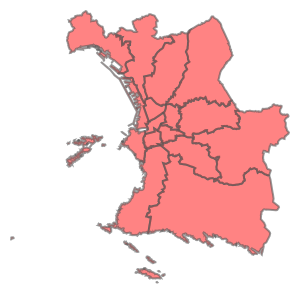

In [4]:
arr = get_geodata(
    "ADMINEXPRESS-COG-CARTO.LATEST:arrondissement_municipal", crs="EPSG:3035"
)

# filter geographical limits of Marseille city
marseille = arr[arr.nom.str.contains("Marseille")]
geoMarseille = marseille.get_geom()
marseilleMap = geopandas.GeoDataFrame(marseille, crs=3035)

geoMarseille

## compute percentage of poor households for each 200m square

In [5]:
# filter dataset on Marseill city
data["check_marseille"] = data.intersects(geoMarseille)
dataMarseille = data[data["check_marseille"]].reset_index(drop=True)

# compute percentage of poor households for each 200m square
cols = ["Men_pauv", "Men"]
dataMarseille[cols] = dataMarseille[cols].apply(pd.to_numeric, errors="coerce")
dataMarseille["Men_pauv_pct"] = (
    dataMarseille["Men_pauv"] / dataMarseille["Men"] * 100
)

## make plot

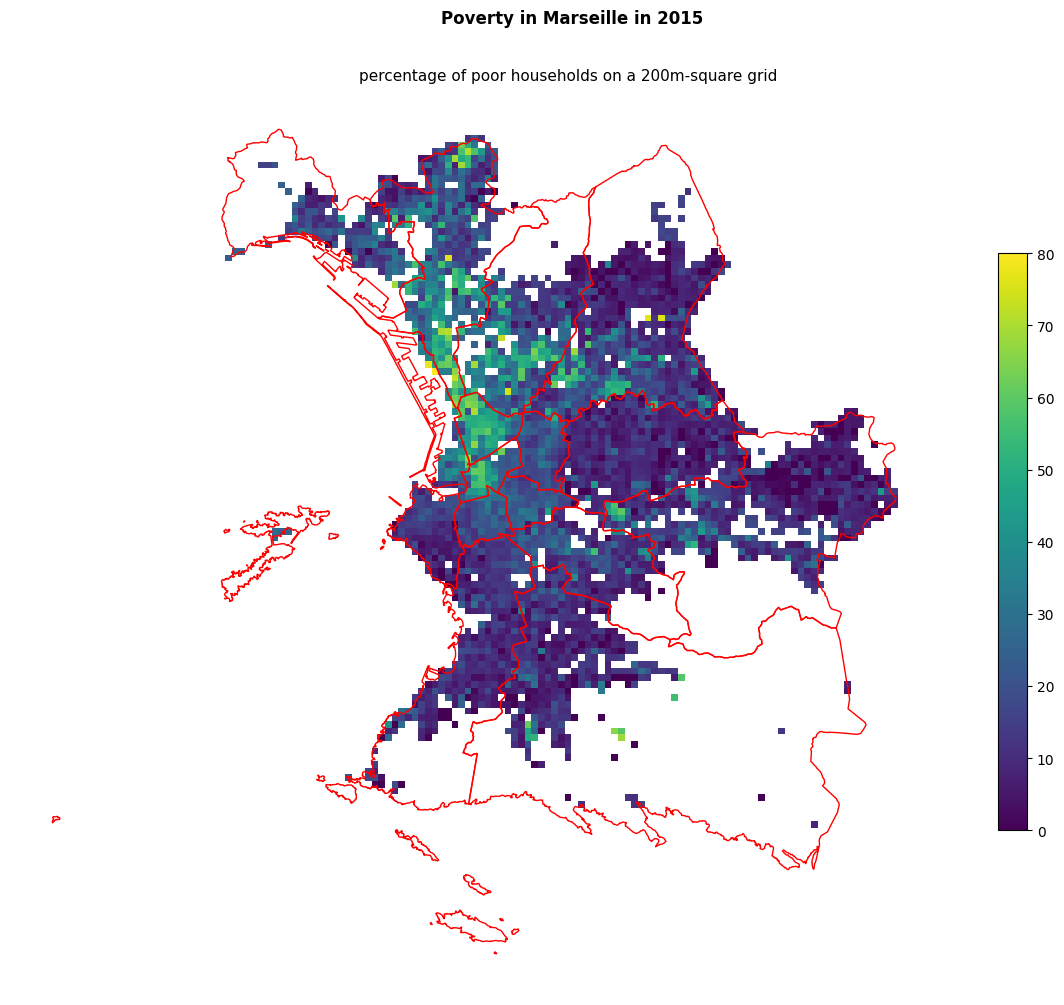

In [6]:
# make plot
ax = dataMarseille.plot(
    column="Men_pauv_pct",
    cmap=cm.viridis,
    legend=True,
    legend_kwds={"shrink": 0.5},
    figsize=(15, 15),
)
marseilleMap.plot(ax=ax, edgecolor="red", color="none")
ax.set_axis_off()
plt.suptitle("Poverty in Marseille in 2015", y=0.85, fontweight="bold")
plt.title(
    "percentage of poor households on a 200m-square grid", size=11, x=0.6
)
plt.show()